In [3]:
from pyts.datasets import load_gunpoint
import matplotlib.pyplot as plt
import numpy as np
import mass_ts as mts

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [4]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

Goal:
Implement shapelet algorithm
Which set of shapelets is optimal

Ideas:
- mass algorithm for distance calculation
- greedy implementation (add next best fit until some criteria)
- divide and conquer
- bootstrapping 

1. sample 

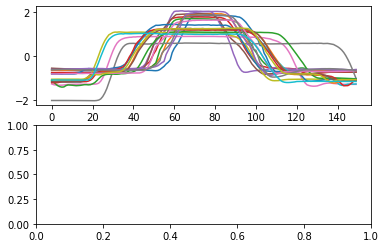

In [5]:
X_train.shape

fig, ax = plt.subplots(2)
ax[0].plot(X_train[:20].T)

In [6]:
X_train

array([[-0.6478854 , -0.64199155, -0.63818632, ..., -0.64042873,
        -0.63866571, -0.63865722],
       [-0.64442658, -0.64540093, -0.64705511, ..., -0.6349345 ,
        -0.6344968 , -0.63159565],
       [-0.77835282, -0.77827907, -0.77715084, ..., -0.70419626,
        -0.70760524, -0.7071202 ],
       ...,
       [-0.77912617, -0.77837863, -0.7757449 , ..., -0.50500603,
        -0.50373099, -0.50438486],
       [-0.70303339, -0.70261754, -0.70250356, ..., -0.64113375,
        -0.64140622, -0.64210896],
       [-1.4357199 , -1.4322717 , -1.4329285 , ..., -1.4354619 ,
        -1.4352821 , -1.4308845 ]])

In [7]:
def sampling(A,n):
    return A[np.random.randint(A.shape[0], size=n), :]
test = sampling(X_train,5)
test.shape

(5, 150)

In [8]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [9]:
x = X_train[:1]

windows = rolling_window(test,30)
print(windows.shape)

# distances = [mts.mass2(x.squeeze(), query) for query in windows.squeeze()]

# x.shape

(5, 121, 30)


1464100
CPU times: user 2.73 s, sys: 35.6 ms, total: 2.76 s
Wall time: 2.8 s


CPU times: user 105 ms, sys: 3.73 ms, total: 108 ms
Wall time: 107 ms


(1, 121, 30)

In [10]:
%%time


def get_candidate_mins(sample_data, shapelet_size = 10):
    """
    Function that calculates the distance of all candidates of a given data set to all all other candidates.
    CAREFUL:
    - memory blows up quickly.
    - contains the zeros (distance of candidates to itself)
    """
    windowed_data = rolling_window(sample_data, shapelet_size)
    return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])

profiles = get_candidate_mins(X_train)

profiles.shape


CPU times: user 24.1 ms, sys: 6.41 ms, total: 30.5 ms
Wall time: 29.6 ms


(50, 50, 141)

In [12]:

%%time


from sklearn import svm
from sklearn.metrics import f1_score

def fit_svm(X,Y):
    """
    Fitting a SVM and returning the f1 score and the calculated margin.
    """
    clf = svm.SVC(kernel='linear')
    # Fit classifier
    clf.fit(X, Y)
    # Calculate margin
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    # Predict
    Y_pred = clf.predict(X)
    # Calculate f1 score
    f1 = f1_score(Y,Y_pred)
    return f1, margin

def get_scores_for_profiles(profiles, y_train):
    """
    Computes the scores for each candidate for each sample in a population of profiles.
    Requires labels.
    """
    list_samples = []
    # Iterating through all smaples in a population of profiles
    for sample in range(profiles.shape[0]):
        # For each candidate in a given sample, compute the boundary and f1 score (SVM)
        sample_scores = [fit_svm(np.expand_dims(profiles[sample,:,cand],axis=1), y_train) for cand in range(profiles.shape[2])]
        list_samples.append(sample_scores)
    return np.array(list_samples)

samples_scores = get_scores_for_profiles(profiles, y_train)


CPU times: user 8.04 s, sys: 55.8 ms, total: 8.1 s
Wall time: 8.15 s


In [ ]:

def closest_neighbor(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def hypothesis_margin(X, y, target_class):
    cumulative_margin = 0
    for x in X[y == target_class]:    
        margin = 1/2*(abs(x - closest_neighbor(X[y!=target_class], x)) - abs(x - closest_neighbor(X[y==target_class], x)))
        cumulative_margin += margin
    return cumulative_margin

start = time.time()
a = hypothesis_margin(X, y, 1)
print(time.time()-start)

In [89]:
per sample take top shapelet (highest f1 score, if same highest margin)


- exclusion zone within sample after first shapelet is detected

(50, 141, 2)